In [2]:
# This is just a scratch cell for pip install commands
%pip install scikit-image

     ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.5 MB 2.4 MB/s eta 0:00:10
      --------------------------------------- 0.4/24.5 MB 4.3 MB/s eta 0:00:06
     - -------------------------------------- 0.7/24.5 MB 4.6 MB/s eta 0:00:06
     - -------------------------------------- 0.9/24.5 MB 4.8 MB/s eta 0:00:05
     - -------------------------------------- 1.1/24.5 MB 4.7 MB/s eta 0:00:05
     -- ------------------------------------- 1.3/24.5 MB 4.7 MB/s eta 0:00:05
     -- ------------------------------------- 1.6/24.5 MB 5.0 MB/s eta 0:00:05
     --- ------------------------------------ 1.9/24.5 MB 5.1 MB/s eta 0:00:05
     --- ------------------------------------ 2.4/24.5 MB 5.6 MB/s eta 0:00:04
     ---- ----------------------------------- 2.7/24.5 MB 5.8 MB/s eta 0:00:04
     ----- ---------------------------------- 3.2/24.5 MB 6.3 MB/s eta 0:00:04
     ------ --------------------------------- 3.7/24.5 MB 6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from textwrap import wrap
from skimage import exposure, color

import os
from sklearn.preprocessing import OneHotEncoder
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

In [4]:
# Loading labels.csv

label_key = pd.read_csv('labels.csv')

In [5]:
# Defining an ImageDatGenerator 
# This is used to homogenize image data for conversion to array
# This can also be used to augment data
# Currently, only used to normalize values between 0.0 and 1.0

datagen = ImageDataGenerator(
    rescale=1.0/255.0
)


In [6]:
# Loading training images and label data
# Using flow_from_directory function of the above ImageDataGenerator object
# Currently working on batches of 64, with no shuffling.
# Fixing output image size to 256x256

train_path = 'traffic_Data/DATA/'
trn_img_arr_list = []
trn_label_arr_list = []

img_itr = datagen.flow_from_directory(
    directory=train_path,
    target_size=(256,256),
    shuffle=False,
    batch_size = 64
)

# Going through the dictionary iterable returned by the above function

for i in  range(len(img_itr)):
  img, label = img_itr[i]
  trn_img_arr_list.append(img)
  trn_label_arr_list.append(label)

# Converting the lists to numpy arrays
# And printing their shape to check dimensions

trn_img_arr = np.concatenate(trn_img_arr_list, axis=0)
trn_label_arr = np.concatenate(trn_label_arr_list, axis=0)
print("Training Image Array dimensions: ",trn_img_arr.shape)
print("Training Labels Array dimensions: ",trn_label_arr.shape)

# From the output of the above print statements, we see:
# Training image array is 4170x256x256x3
# Label array is 4170x58
# Thus, there are 4170 training images, each of size 256x256, and 3 colour channels
# The labels are also one-hot encoded

# Note: ImageDataGenerator.flow_from_directory expects image data to be organized as such:
# Images are to be organized into subfolders based on label
# The name of each subfolder is taken as the label name
# Fortunately, our data is already structured as required

Found 4170 images belonging to 58 classes.
Training Image Array dimensions:  (4170, 256, 256, 3)
Training Labels Array dimensions:  (4170, 58)


In [7]:
# Loading test images and label data
# The process is identical to the previous cell
# THIS CELL DOES NOT WORK!!
# TEST DATA SHOULD BE ORGANIZED AS REQUIRED FIRST!!
test_path = 'traffic_Data/TEST_STRUCTURED'
tst_img_arr_list = []
tst_label_arr_list = []


img_itr = datagen.flow_from_directory(
    directory=test_path,
    target_size=(256,256),
    shuffle=False,
    batch_size = 64
)

for i in  range(len(img_itr)):
  img, label = img_itr[i]
  tst_img_arr_list.append(img)
  tst_label_arr_list.append(label)

tst_img_arr = np.concatenate(tst_img_arr_list, axis=0)
tst_label_arr = np.concatenate(tst_label_arr_list, axis=0)
print(tst_img_arr.shape)
print(tst_label_arr.shape)

# According to the print statements, we see:
# Test Image Array dimensions: 1994x256x256x3
# Test Labels Array dimensions: 1994x58
# Thus, there are 1994 test images, each of size 256x256, with 3 colour channels
# The labels are also one-hot encoded

Found 1994 images belonging to 58 classes.
(1994, 256, 256, 3)
(1994, 58)


Visualizing Data

In [28]:
# Defining a function to create a bar plot for class distribution
# Called twice, once for training set and once for test set

def class_balance_plot(x, y, bar_width=0.5, title="Title"):
    plt.figure(figsize=(10,10))
    plt.bar(x, y, width=bar_width)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, ha='center')
    plt.title(title)
    plt.tight_layout()

    return plt.gca()

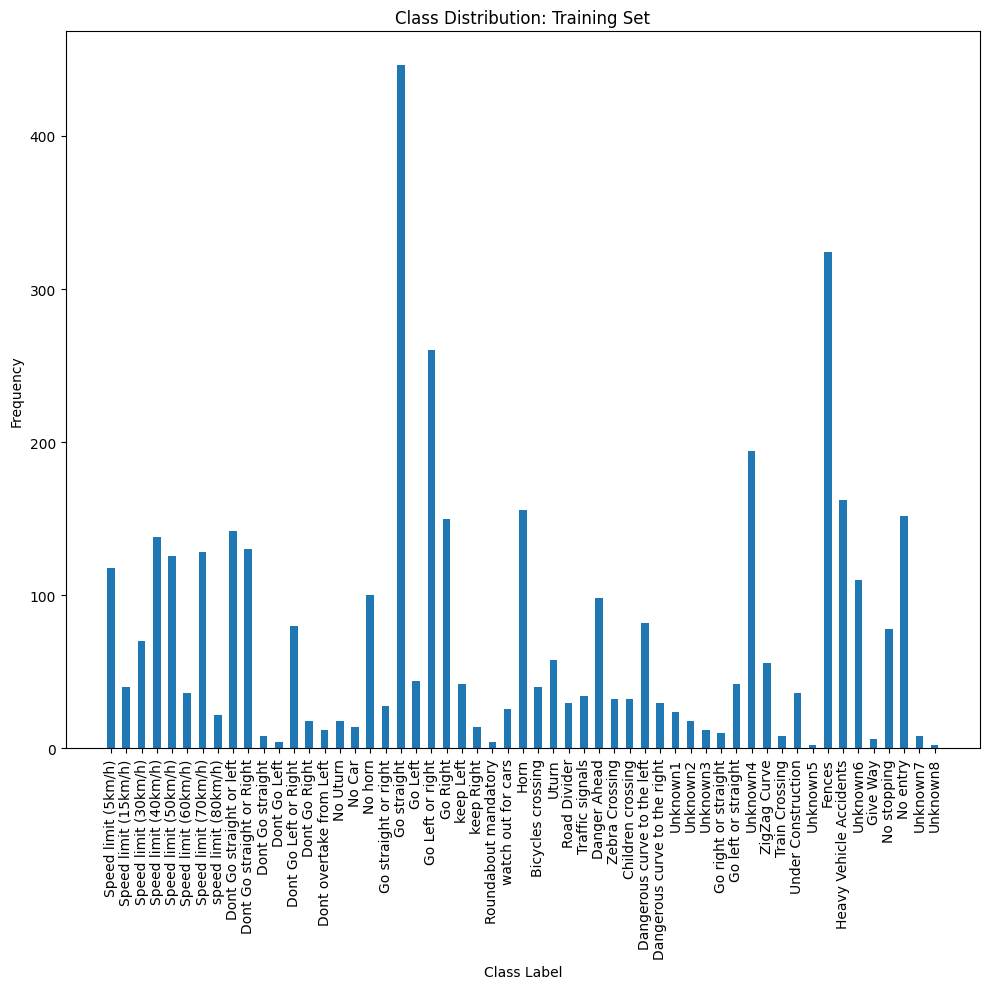

In [29]:
# Visualising class balance in training set

class_names = label_key['Name'].values
trn_class_count = np.sum(trn_label_arr, axis=0)
trn_chart = class_balance_plot(class_names, trn_class_count, title="Class Distribution: Training Set")
plt.show()

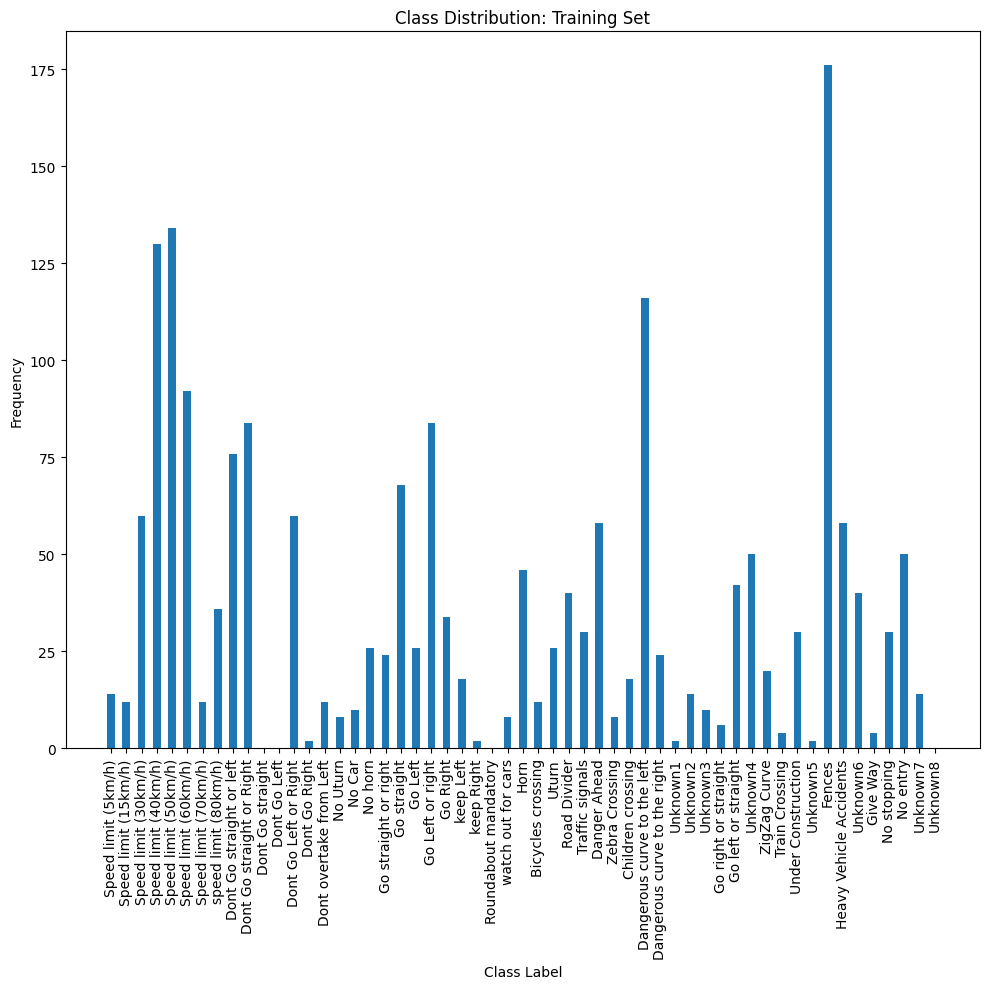

In [30]:
# Visualizing class balance in test set

class_names = label_key['Name'].values
tst_class_count = np.sum(tst_label_arr, axis=0)
trn_chart = class_balance_plot(class_names, tst_class_count, title="Class Distribution: Training Set")
plt.show()

Addressing Imbalance in Training Set

In [89]:
# Defining thresholds for demarcating minority, average, and majority classes
# based on mean, not percentiles
# Adjust as needed

min_thres = np.mean(trn_class_count) 
maj_thres = np.mean(trn_class_count) 

# Getting indices of the minority and majority classes
# based on above-defined thresholds

minority_classes_idx = np.squeeze(np.array(np.where(trn_class_count < min_thres)))
print(minority_classes_idx)
majority_classes_idx = np.squeeze(np.array(np.where(trn_class_count >= maj_thres)))
print(majority_classes_idx)

[ 1  2  5  7 10 11 13 14 15 16 18 20 22 25 26 27 28 30 31 32 33 35 36 37
 39 40 41 42 43 44 46 47 48 49 53 56 57]
[ 0  3  4  6  8  9 12 17 19 21 23 24 29 34 38 45 50 51 52 54 55]


In [90]:
# Trying Under/Oversampling:
# Oversample small classes and Undersample large classes

# Defining accumulator lists
upsample_img = []
upsample_label = []
downsample_img = []
downsample_label = []


for idx in minority_classes_idx:
    min_img_rows = trn_label_arr[:,idx]
    min_img_arr = trn_img_arr[min_img_rows == 1, :, :,:]
    
    upsample_batch = resample(min_img_arr,
                            replace=True,
                            n_samples=int(np.mean(trn_class_count)))
    
    label_temp = np.zeros((len(upsample_batch), len(trn_class_count)))
    label_temp[:,idx] = 1

    upsample_img.append(upsample_batch)
    upsample_label.append(label_temp)

upsample_img = np.concatenate(upsample_img, axis=0)
print(upsample_img.shape)
upsample_label = np.concatenate(upsample_label, axis=0)
print(upsample_label.shape)

for idx in majority_classes_idx:
    maj_img_rows = trn_label_arr[:,idx]
    maj_img_arr = trn_img_arr[maj_img_rows == 1, :, :,:]
    
    downsample_batch = resample(maj_img_arr,
                            replace=True,
                            n_samples=int(np.mean(trn_class_count)))
    
    label_temp = np.zeros((len(downsample_batch), len(trn_class_count)))
    label_temp[:,idx] = 1

    downsample_img.append(downsample_batch)
    downsample_label.append(label_temp)

downsample_img = np.concatenate(downsample_img, axis=0)
print(downsample_img.shape)
downsample_label = np.concatenate(downsample_label, axis=0)
print(downsample_label.shape)

    


(2627, 256, 256, 3)
(2627, 58)
(1491, 256, 256, 3)
(1491, 58)


[71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71. 71.
 71. 71. 71. 71.]
(4118, 256, 256, 3)
(4118, 58)


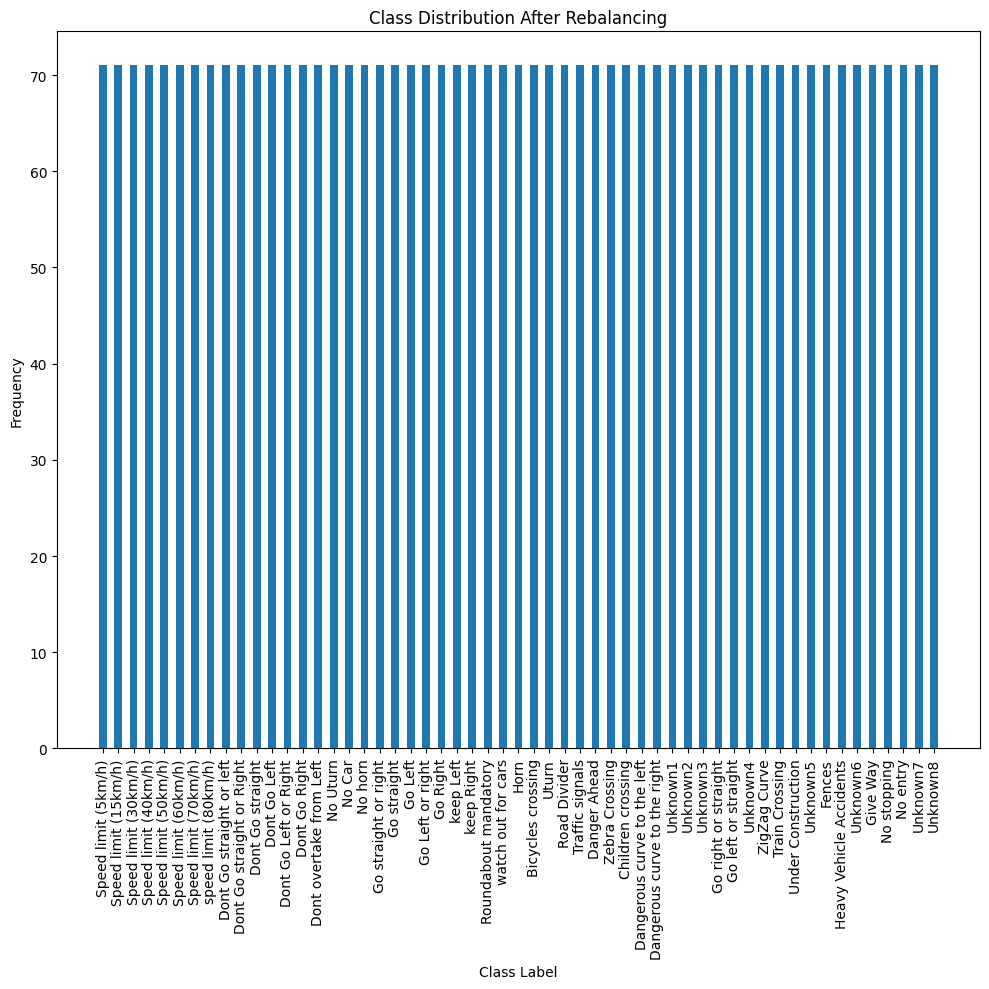

In [94]:
# Joining the upsampled and downsampled sets
# Getting the class distribution of equalized classes
# Checking the shape of the new balanced set
trn_img_arr_eql = np.concatenate((upsample_img, downsample_img), axis=0)
trn_label_arr_eql = np.concatenate((upsample_label, downsample_label), axis=0)

class_count_eql = trn_label_arr_eql.sum(axis=0)
print(class_count_eql)
print(trn_img_arr_eql.shape)
print(trn_label_arr_eql.shape)

equalized_distribution = class_balance_plot(class_names, class_count_eql, title="Class Distribution After Rebalancing")
plt.show()

As we can see from the above graph, the classes are balanced